In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential
import math
from tensorflow.keras.models import load_model

from music21 import converter, instrument, note, chord, stream, key
import glob
import music21

from keras.utils import np_utils
import os

FONTSIZE=24
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

# Load in Generator

In [5]:
model=load_model('./results_boost10_clip0.001/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_WeightClip_0.001_Gen_epoch_650.h5')

# Produce Images

In [6]:
def generate_latent_space(n_samples,latent_dim):
    
    xinput=np.random.randn(n_samples*latent_dim)
    xinput=xinput.reshape((n_samples,latent_dim))
    
    return xinput

In [8]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
print(x_fake.shape)

(1, 96, 96, 4)


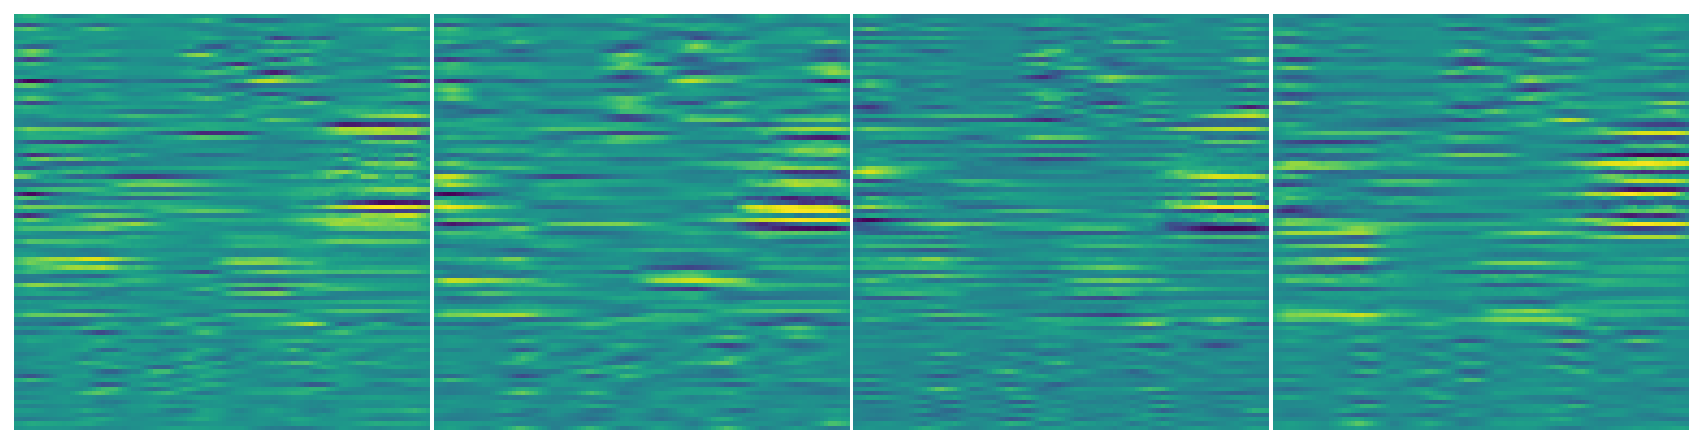

In [12]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [23]:
# include pixels above a threshold

def clip_plots(generated_plots,threshold=0.5):
    
    num_plots=generated_plots.shape[0]
    image_height=generated_plots.shape[1]
    image_width=generated_plots.shape[2]
    num_channels=generated_plots.shape[3]
    
    generated_plots_clipped=np.zeros((num_plots,image_height,image_width,num_channels))
    
    for i in range(num_plots):
        for j in range(image_height):
            for k in range(image_width):
                for m in range(num_channels):
                    
                    pixel_check=generated_plots[i,j,k,m]
                    
                    if pixel_check>threshold:
                        
                        generated_plots_clipped[i,j,k,m]=1
                        
    return generated_plots_clipped

x_fake_clipped=clip_plots(x_fake,threshold=0.6)

(-0.5, 383.5, 95.5, -0.5)

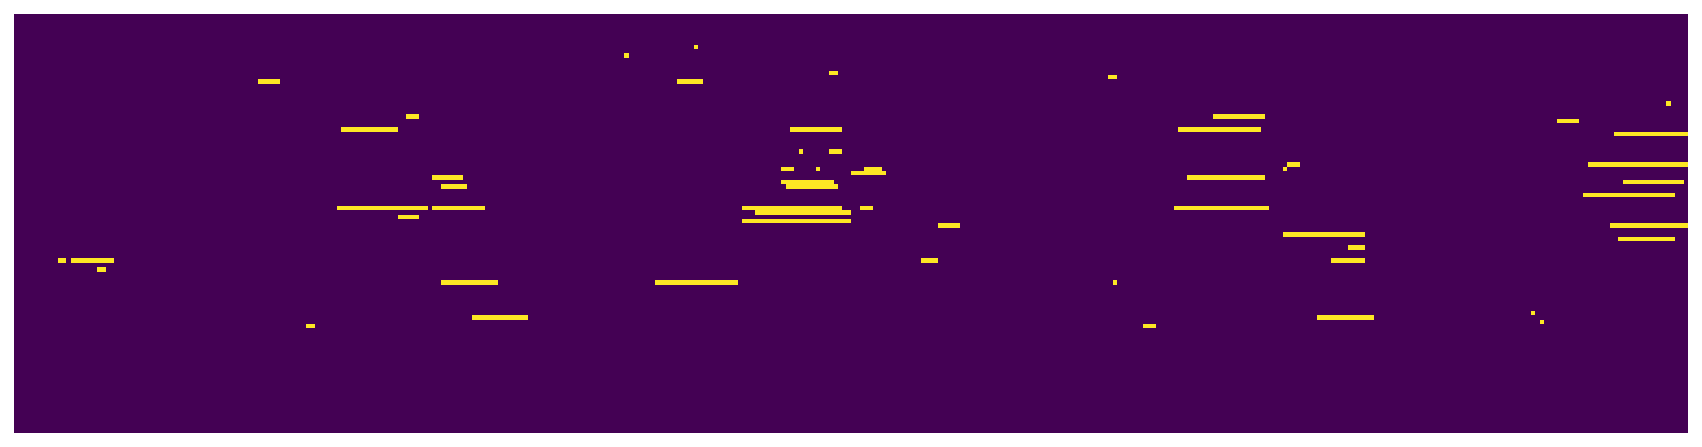

In [24]:
image=np.zeros((96,96*4))
image[:,:96]=x_fake_clipped[0,:,:,0]
image[:,96:96*2]=x_fake_clipped[0,:,:,1]
image[:,96*2:96*3]=x_fake_clipped[0,:,:,2]
image[:,96*3:]=x_fake_clipped[0,:,:,3]

plt.imshow(image)
plt.axis('off')

In [25]:
print(x_fake_clipped[0,:,10,0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Convert Images to MIDIs

In [26]:
# make a dictionary that maps ints to notes

#this will have key=integer value=pitch

#I'm dropping our lowest octave down to 0 and moving up 8 so our images can be squares

pitch_dict_fifths={}

min_octave=0
num_octaves=8

notes=['A','E','B','F#','C#','G#','D#','A#','F','C','G','D']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict_fifths[int(count)]=pitch
        
num_pitches=count+1
print(num_pitches)

96


In [27]:
print(pitch_dict_fifths[54])

D#4


In [28]:
def convert_to_midi(x_fake, filename, pitch_dict,confidence=0.8,size=96,num_channels=4,pixel_length=float(1/12) ):
    '''
    x_fake - generator produced image. shape=(1,size,size,num_channels)
    confidence - value pixel must have to be considered a note
    size - image size
    num_channels - number of image channels
    pixel_length - conversion from pixels to offsets 1 column=pixel_length offsets
    '''
    
    #convert image with channels to one continuous image
    image=np.zeros((size,size*num_channels))
    for i in range(num_channels):
        image[:,size*i:size*(i+1)]=x_fake[0,:,:,i]
    
    #collect offsets, pitches and durations
    
    offsets=[]
    pitches=[]
    durations=[]
    for row in range(image.shape[0]):
        
        note_previous=False #this will help us fill durations, does the previous column in this row contain a note?
        
        for column in range(image.shape[1]):
            
            offset=pixel_length*column
            pitch=pitch_dict[row]
            
            if image[row,column]>=confidence:
                #we have a note at this pixel
                
                if note_previous:
                    # the current pixel is a continuation of a previous note
                    durations[-1]+=pixel_length
                    
                elif not note_previous:
                    # the current pixel is the start of a new note
                    offsets.append(offset)
                    pitches.append(pitch)
                    durations.append(pixel_length) 
                
                note_previous=True
            else:
                note_previous=False
    
                
    #convert offsets, pitches, and durations to MIDI file
    output_notes=[]
    for i in range(len(pitches)):
        
        pitch=pitches[i]
        offset=offsets[i]
        duration=durations[i]
        
        new_note = note.Note(pitch,ql=duration)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
        
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    
    
    

In [29]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_1.mid',pitch_dict=pitch_dict_fifths)

In [36]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake,threshold=0.5)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


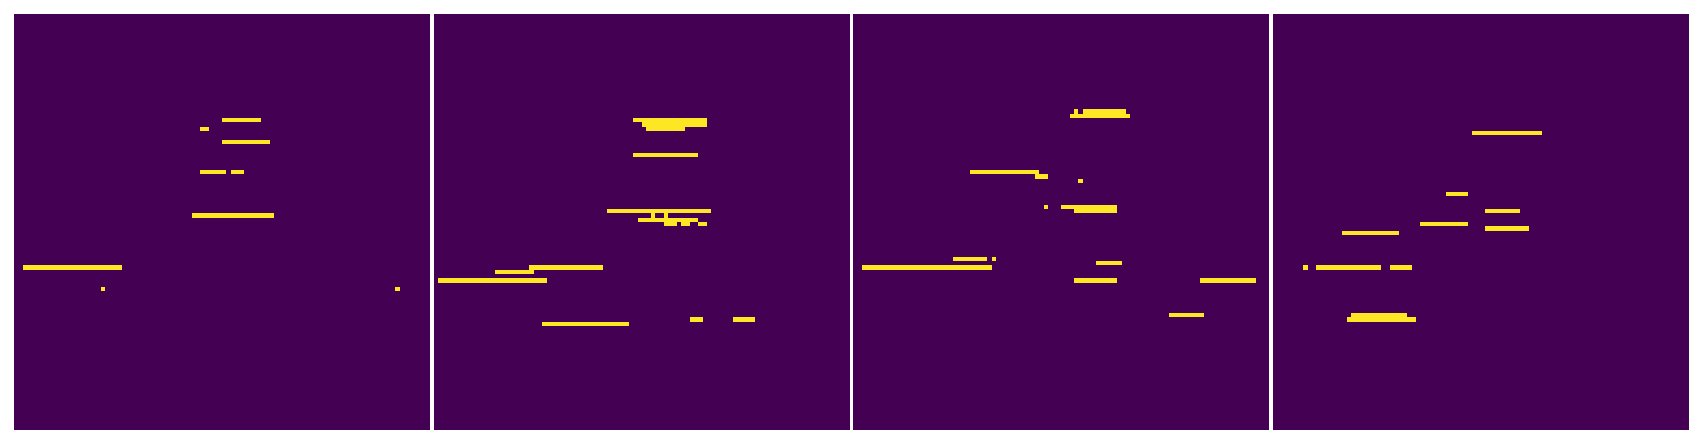

In [37]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i])
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [38]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_2.mid',pitch_dict=pitch_dict_fifths)

In [39]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


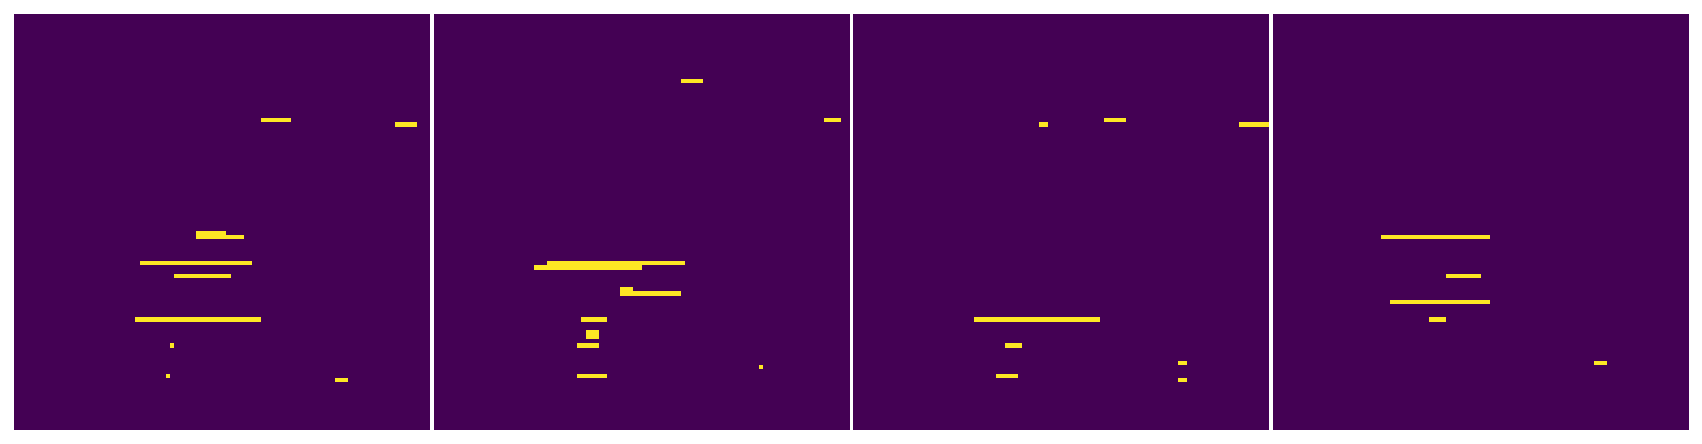

In [43]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [42]:
#midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_3.mid',pitch_dict=pitch_dict_fifths)

In [53]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


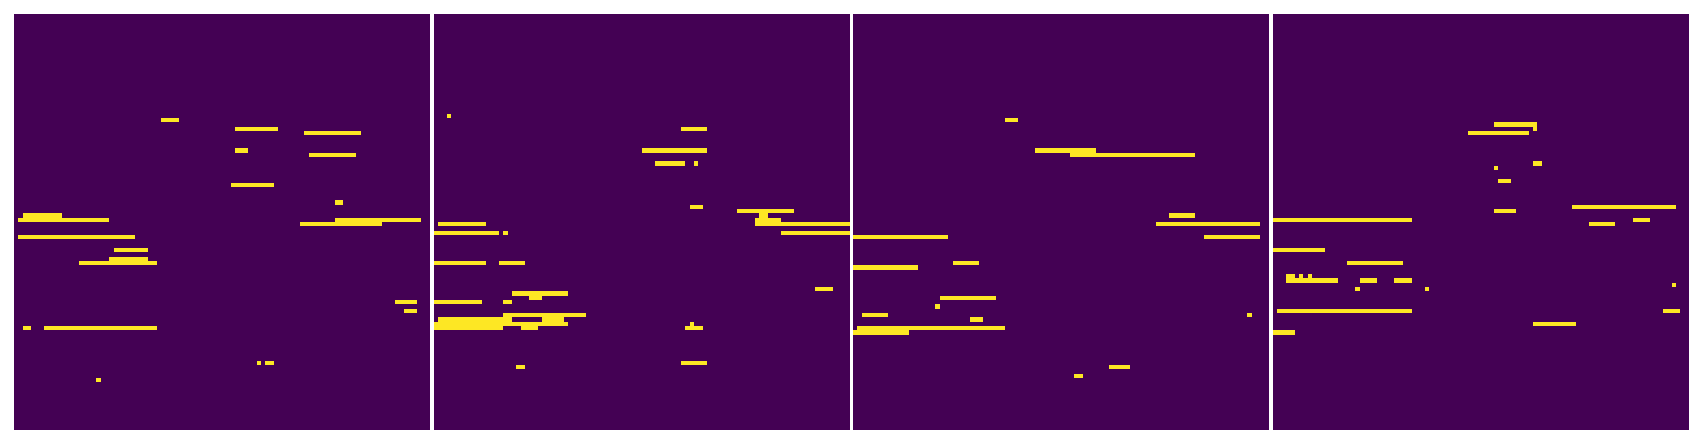

In [54]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [55]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_4.mid',pitch_dict=pitch_dict_fifths)

# Loading in the fully trained generator (extra 100 epochs)

In [56]:
model=load_model('./results_boost10_clip0.001/WassGan_fifths_Gfilters_48_48_48_Cfilters_64_64_Gstrides_12-2_2-4_Cstrides_2_2_Cboost_10_WeightClip_0.001_Gen_epoch_750.h5')

In [57]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


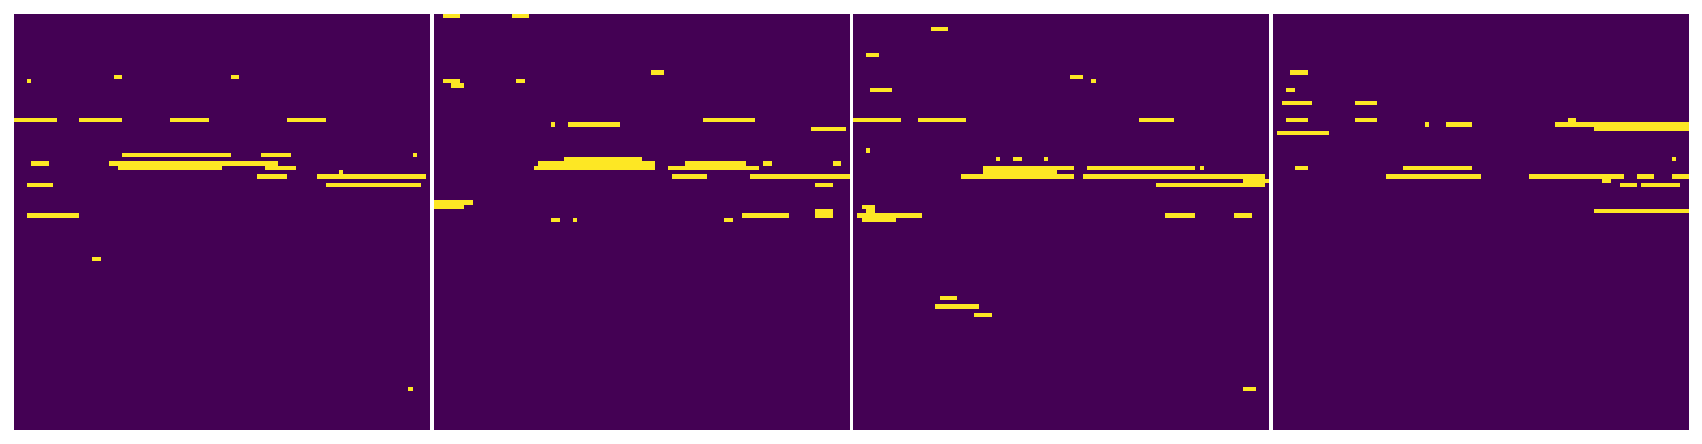

In [58]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [59]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_5.mid',pitch_dict=pitch_dict_fifths)
#Ok this one actually has a beautiful melody at points but the notes accompanying it are garbage

In [103]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake,threshold=0.5)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


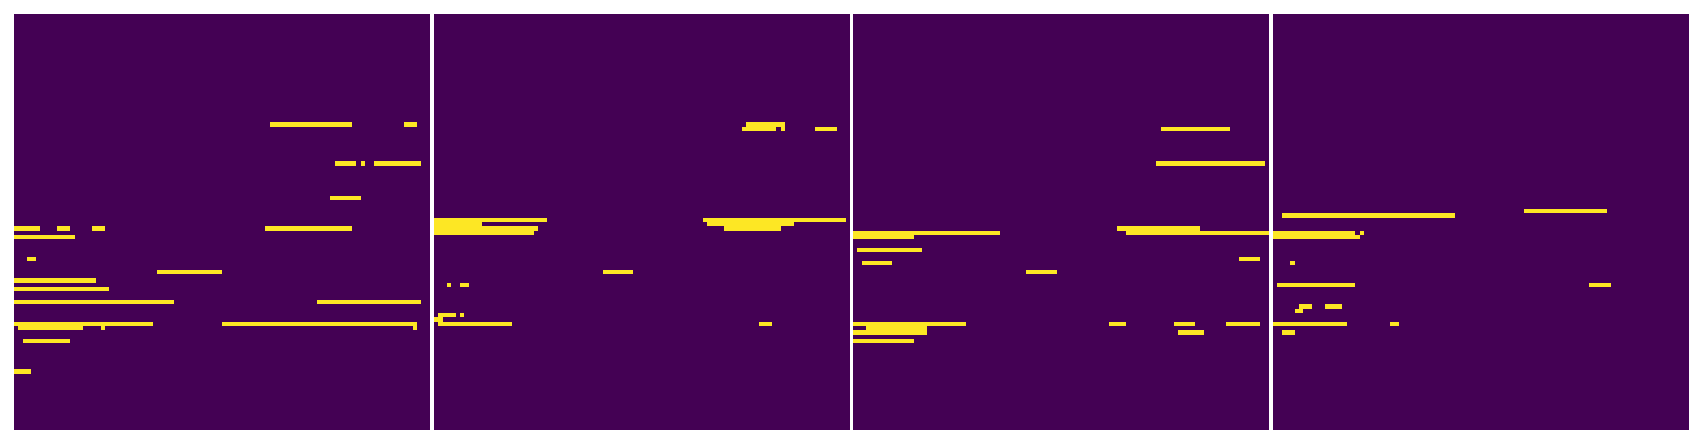

In [104]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [105]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_6.mid',pitch_dict=pitch_dict_fifths)

In [106]:
xinput=generate_latent_space(1,latent_dim=20)
x_fake=model.predict(xinput)
x_fake_clipped=clip_plots(x_fake,threshold=0.5)
print(x_fake_clipped.shape)

(1, 96, 96, 4)


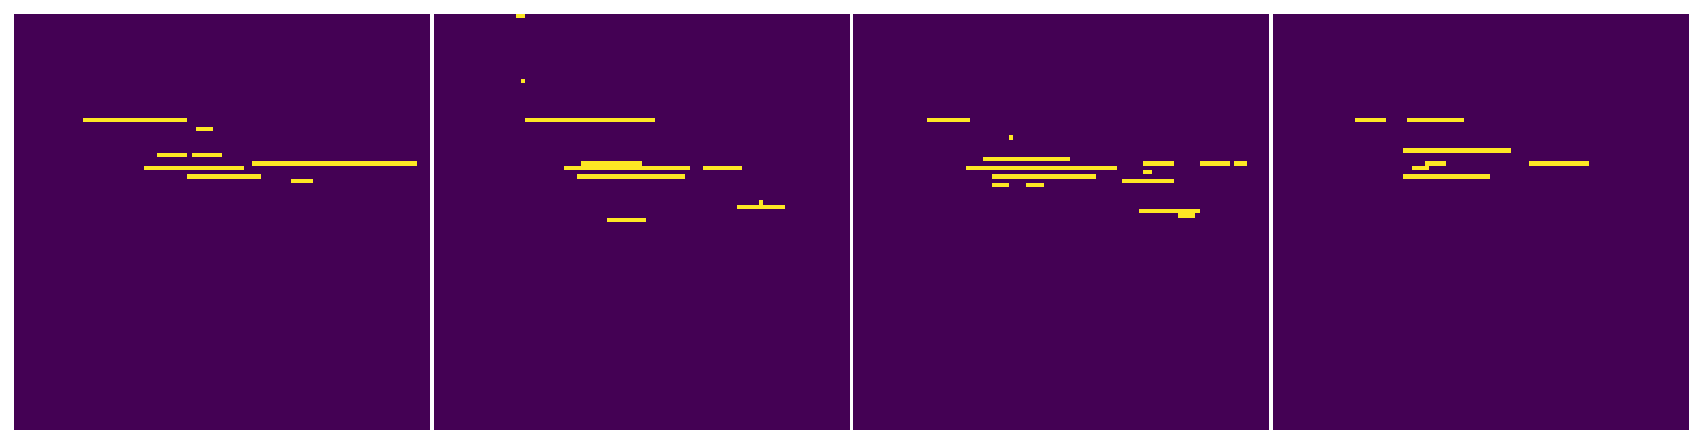

In [107]:
num_channels=4
fig,axs=plt.subplots(nrows=1,ncols=num_channels)
for i in range(num_channels):
    axs[i].axis('off')
    axs[i].imshow(x_fake_clipped[0, :, :, i],origin='lower')
plt.subplots_adjust(wspace=0.01,hspace=0.01)

In [108]:
midi_file=convert_to_midi(x_fake_clipped,filename='./midis/boost10_clip0.001_7.mid',pitch_dict=pitch_dict_fifths)